In [14]:
import pandas as pd

import numpy as np

import os,sys

from shapely.geometry import Point, Polygon

import copy

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import time

from scipy.stats import pearsonr

# from __future__ import division

from scipy.stats import rv_continuous

import scipy


from scipy.optimize import curve_fit

from scipy.stats import gamma


from scipy.stats import shapiro


from scipy.stats import mannwhitneyu

from scipy.stats import ks_2samp


# Param

In [15]:
Load_path='./Data/GAIA/'

Summary_path='./Data/Summary/'

Save_Path='./Data/Estimation/'

Labels=['A','B','C']

# The number of Shifts

In [16]:
'''The Number of Drivers'''

Get_day=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[8:10]

Summary=pd.read_csv(os.path.join(Summary_path,'Summary.csv'))

Driver_Df=pd.read_csv(os.path.join(Summary_path,'Driver_Df.csv'))

Driver_Df=Driver_Df[['Driver_id','label']]

Summary=Summary.merge(Driver_Df,on='Driver_id')

Summary=Summary.drop_duplicates(subset=['Driver_id'])

Summary['day']=Summary.apply(lambda x:Get_day(x['Start Time']),axis=1)

Summary=Summary.loc[Summary['day']=='14']

Count_Stat=Summary.groupby('label').count()

Count_Stat['label']=Count_Stat.index

Count_Stat=Count_Stat.reset_index(drop=True)

Count_Stat=Count_Stat.rename(columns={'Driver_id':'Num'})

Count_Stat=Count_Stat[['label','Num']]


Count_Stat

,label,Num
0,A,18919
1,B,5120
2,C,13457


# The number of Shifts

In [17]:
Feature_df=pd.read_csv(os.path.join(Summary_path,'Feature_df.csv'))

Feature_df=Feature_df[['Driver_id',\
                       'Total Number of Shifts']]

Driver_Df=pd.read_csv(os.path.join(Summary_path,'Driver_Df.csv'))

Driver_Df=Driver_Df[['Driver_id','label']]

Feature_df=Feature_df.merge(Driver_Df,on='Driver_id')

Multinomial=pd.DataFrame([],columns=['Cluster','Total Number of Shifts','Prob'])

for label in Labels:
    
    Temp = Feature_df.loc[Feature_df['label']==label]
    
    Temp = Temp.groupby('Total Number of Shifts').count()
    
    Temp['Total Number of Shifts']=Temp.index
    
    Temp=Temp.reset_index(drop=True)
    
    Temp=Temp[['Total Number of Shifts','Driver_id']]
    
    Temp=Temp.loc[Temp['Total Number of Shifts']<=3]
    
    Temp=Temp.rename(columns={'Driver_id':'Num'})
    
    Sum=Temp['Num'].sum()
    
    Temp['Prob']=Temp.apply(lambda x:x['Num']/Sum,axis=1)
    
    Temp['Cluster']=label
    
    Temp=Temp[['Cluster','Total Number of Shifts','Prob']]
    
    Multinomial=pd.concat([Multinomial,Temp],ignore_index=True)

Multinomial_dic={l:{} for l in Labels}

for idx,row in Multinomial.iterrows():
    cluster=row['Cluster']
    num=row['Total Number of Shifts']
    prob=row['Prob']
    
    Multinomial_dic[cluster][num]=prob
    
np.save(os.path.join(Save_Path,'Multinomial.npy'),Multinomial_dic)

Multinomial_dic

{'A': {1: 0.5103813608618429, 2: 0.3767538178743999, 3: 0.11286482126375715},
 'B': {1: 0.7910633744633013,
  2: 0.20812395877070608,
  3: 0.0008126667659926047},
 'C': {1: 0.8650817266230589, 2: 0.12803921667515622, 3: 0.006879056701784823}}

# First Shift Start Time

In [18]:
Feature_df=pd.read_csv(os.path.join(Summary_path,'Feature_df.csv'))

Feature_df=Feature_df[['Driver_id','First Shift Start Time']]

Get_hour=lambda x:int(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[11:13])+float(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[14:16])/60.0

Feature_df['First Shift Start Hour']=Feature_df.apply(lambda x:Get_hour(x['First Shift Start Time']),axis=1)

Feature_df=Feature_df[['Driver_id','First Shift Start Hour']]

Feature_df=Feature_df.merge(Driver_Df,on='Driver_id')

Feature_df


,Driver_id,First Shift Start Hour,label
0,0000131d486b69eb77ab6e9e7cca9f4c,11.950000,A
1,000049d47b79747ad9927ba1bf5f4126,8.400000,A
2,00005adc52a78e1630cfb50e4bd0f89e,19.150000,C
3,000079a54709c3ce262a21327bebc5a7,9.483333,A
4,0000839aee24e6f8d7856b7d5a89d665,15.816667,C
5,000088d299916f2e44ef335f3752ae61,6.450000,A
6,0000a3c4817080300cf3ef7d58faaad1,0.316667,A
7,0000beca799d88e6810faf33df585dec,14.450000,C
8,0000dbe2f9b7a09864e39eb56a415726,7.300000,B
9,0001213d9f0ff0a68bcf8fbd0ca4bda8,9.366667,B


### KS Test

In statistics, the Kolmogorov–Smirnov test (K–S test or KS test) is a nonparametric test of the equality of continuous (or discontinuous, see Section 2.2), one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). It is named after Andrey Kolmogorov and Nikolai Smirnov.



The Kolmogorov–Smirnov test can be modified to serve as a goodness of fit test. In the special case of testing for normality of the distribution, samples are standardized and compared with a standard normal distribution. 


This is equivalent to setting the mean and variance of the reference distribution equal to the sample estimates, and it is known that using these to define the specific reference distribution changes the null distribution of the test statistic (see Test with estimated parameters). Various studies have found that, even in this corrected form, the test is less powerful for testing normality than the Shapiro–Wilk test or Anderson–Darling test.


Cluster A KS Test P-Value: 0.34388571222170117
Cluster B KS Test P-Value: 0.44312540269882544
Cluster C KS Test P-Value: 0.6766201497002462


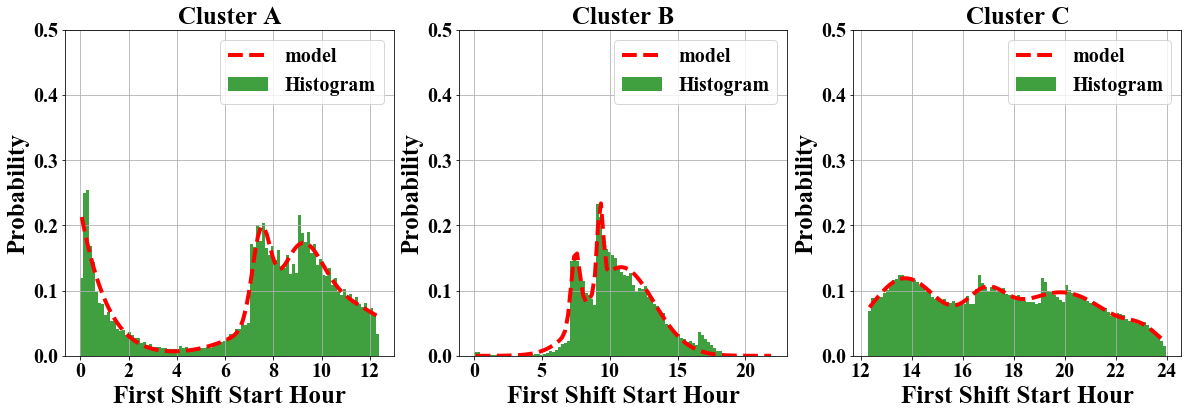

In [19]:
def gauss(x,mu,sigma,A):
    
    return A*np.exp(-(x-mu)**2/2/sigma**2)*(1/np.sqrt(2*np.pi)/sigma)

def gauss_1(x,mu1,sigma1,A):
    return gauss(x,mu1,sigma1,A)
def gauss_2(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def gauss_3(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

def gauss_4(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3,mu4,sigma4,A4):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)

def Arr_Cut(arr,cut_points):
    
    output=list()
    
    for i in range(len(cut_points)):

        output.append(arr[(arr<cut_points[i][1])&(arr>=cut_points[i][0])])
            
    return output

def Get_fit(arr,X,Y):
    
    mu=list()
    
    sigma=list()
    
    expected=list()
    
    for i in range(len(arr)):
        
        mu.append(scipy.stats.norm.fit(arr[i])[0])
        
        sigma.append(scipy.stats.norm.fit(arr[i])[1])
        
        expected.append(scipy.stats.norm.fit(arr[i])[0])
        
        expected.append(scipy.stats.norm.fit(arr[i])[1])
        
        expected.append(1)
        
    params,cov=curve_fit(eval("gauss_%s"%str(len(arr))),X,Y,expected,maxfev=20000)
        
    Y_=eval("gauss_%s"%str(len(arr)))(X,*params)
    
    return Y_,params
        
        
            


tag='B'


Cols=['mu1','sigma1','A1',\
      'mu2','sigma2','A2',\
      'mu3','sigma3','A3',\
      'mu4','sigma4','A4']




figsize = 20,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,3,figsize=figsize)

Param_A={}

Param_B={}

Param_C={}

for i in range(3):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]



for tag in ['A','B','C']:
    
    Sample=copy.deepcopy(Feature_df.loc[Feature_df['label']==tag])
    
    Sample_arr=np.array(Sample['First Shift Start Hour'])
    
    Sample_arr.sort()

    if tag=='A':
        
        Param_A['min'] = Sample_arr[int(0.05 * len(Sample_arr))]
    
        Param_A['max'] = Sample_arr[int(0.95 * len(Sample_arr))]

        Y, X, _ = ax1[0].hist(Sample_arr, 100,label='Histogram',facecolor='g', density=True, alpha=0.75)


        '''A'''
        
        arr=Sample_arr[int(0.05 * len(Sample_arr)):int(0.95 * len(Sample_arr))+1]
        
        arr=Arr_Cut(arr,[[0,6],[6,9],[8,10],[10,12]])
        
        X=(X[1:]+X[:-1])/2
        
        Y_,params=Get_fit(arr,X,Y)

        
        ax1[0].plot(X,Y_,'r--',lw=4,label='model')
        
        ax1[0].set_title('Cluster '+ tag,font_label)
        
        '''Test'''
        
        print('Cluster '+tag+' KS Test P-Value:', ks_2samp(Y,Y_).pvalue)
        
        for i in range(len(params)):

            Param_A[Cols[i]]=params[i]


    if tag=='B':
        
        Param_B['min'] = Sample_arr[int(0.05 * len(Sample_arr))]
    
        Param_B['max'] = Sample_arr[int(0.95 * len(Sample_arr))]

        Y, X, _ = ax1[1].hist(Sample_arr, 100,label='Histogram',facecolor='g', density=True, alpha=0.75)

        '''B'''
        
        arr=Sample_arr[int(0.05 * len(Sample_arr)):int(0.95 * len(Sample_arr))+1]
        
        arr=Arr_Cut(arr,[[0,8],[8,12],[12,24]])
        
        X=(X[1:]+X[:-1])/2
        
        Y_,params=Get_fit(arr,X,Y)

        ax1[1].plot(X,Y_,'r--',lw=4,label='model')
        
        ax1[1].set_title('Cluster '+ tag,font_label)
        
        '''Test'''
        
        print('Cluster '+tag+' KS Test P-Value:', ks_2samp(Y,Y_).pvalue)

        for i in range(len(params)):

            Param_B[Cols[i]]=params[i]

    if tag=='C':
        
        Param_C['min'] = Sample_arr[int(0.05 * len(Sample_arr))]
    
        Param_C['max'] = Sample_arr[int(0.95 * len(Sample_arr))]

        Y, X, _ = ax1[2].hist(Sample_arr, 100,label='Histogram',facecolor='g', density=True, alpha=0.75)

        '''C'''

        arr=Sample_arr[int(0.05 * len(Sample_arr)):int(0.95 * len(Sample_arr))+1]
        
        arr=Arr_Cut(arr,[[12,16],[16,18],[18,20],[20,24]])
        
        X=(X[1:]+X[:-1])/2
        
        Y_,params=Get_fit(arr,X,Y)

        ax1[2].plot(X,Y_,'r--',lw=4,label='model')
        
        ax1[2].set_title('Cluster '+ tag,font_label)
        
        '''Test'''
        
        print('Cluster '+tag+' KS Test P-Value:', ks_2samp(Y,Y_).pvalue)

        for i in range(len(params)):

            Param_C[Cols[i]]=params[i]
        
for i in range(3):
    
    ax1[i].set_ylabel('Probability',font_label)

    ax1[i].set_xlabel('First Shift Start Hour',font_label)

    ax1[i].legend(loc = 'upper right',prop=font_legend)

    ax1[i].set_ylim([0,0.5])
    
    ax1[i].grid()


plt.show()


np.save(os.path.join(Save_Path,'Param_A.npy'),Param_A)

np.save(os.path.join(Save_Path,'Param_B.npy'),Param_B)

np.save(os.path.join(Save_Path,'Param_C.npy'),Param_C)




# Shift Duration Time

In [20]:
Summary=pd.read_csv(os.path.join(Summary_path,'Summary.csv'))

Summary=Summary[['Driver_id', 'Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time','End Time','Occupied Distance(m)']]

Driver_Df=pd.read_csv(os.path.join(Summary_path,'Driver_Df.csv'))

Driver_Df=Driver_Df[['Driver_id','label']]

Summary=Summary.merge(Driver_Df,on='Driver_id')

Get_3600=lambda x:round(x/3600.0,2)

Summary['Start Hour']=Summary.apply(lambda x:int(Get_hour(x['Start Time'])),axis=1)

Summary['Shift Duration (h)']=Summary.apply(lambda x:Get_3600(x['Shift Duration (sec)']),axis=1)

Summary=Summary.loc[Summary['Shift Duration (h)']<20]

Summary


,Driver_id,Shifts,Order Number,Shift Duration (sec),Occupied Time (sec),Start Time,End Time,Occupied Distance(m),label,Start Hour,Shift Duration (h)
0,0000131d486b69eb77ab6e9e7cca9f4c,1,3,6303,4535,1477972625,1477978928,13518,A,11,1.75
1,000211a97ba2b768ef941593bf1ae1a5,1,1,966,966,1477963781,1477964747,4914,A,9,0.27
2,000211a97ba2b768ef941593bf1ae1a5,1,4,6251,8455,1478002015,1478008266,33656,A,20,1.74
3,000770ada4aa5d856b5a766fb6bf7cf1,1,5,11649,5274,1477962292,1477973941,26231,A,9,3.24
4,0007a380800445346fff19afc4071ce3,1,1,1419,1419,1477963840,1477965259,5453,A,9,0.39
5,0008c9d2ac91c00ef8b3ef80eba02a06,1,3,4074,2729,1477967006,1477971080,16418,A,10,1.13
6,0008c9d2ac91c00ef8b3ef80eba02a06,1,2,3937,3431,1477984364,1477988301,19661,A,15,1.09
7,0008c9d2ac91c00ef8b3ef80eba02a06,1,3,10959,2406,1478005496,1478016455,15709,A,21,3.04
8,00095da02ea38d4d8eaa120201e38ae9,1,1,1522,1522,1477965144,1477966666,5050,A,9,0.42
9,000d0e4bd461b1f964daeb6d21868757,1,5,7148,5668,1477940181,1477947329,48705,A,2,1.99


In [21]:
Duration_Df=pd.DataFrame([])

def Get_bound(arr):
    
    arr=np.array(arr)
    
    arr.sort()
    
    min_=arr[int(0.05 * len(arr))]
    
    max_=arr[int(0.95 * len(arr))]
    
    return min_,max_

def Get_sort(arr):
    
    arr=np.array(arr)
    
    arr.sort()
    
    arr[int(0.05 * len(arr)):int(0.95 * len(arr))]
    
    return arr

def KS_Test(arr):

    figure, ax = plt.subplots(figsize=figsize)

    Y, X, _ = ax.hist(arr, 100,label='Histogram',facecolor='g', density=True, alpha=0.0)
    
    plt.close()
    
    X=(X[1:]+X[:-1])/2
    
    mu=np.mean(arr)
    
    sigma=np.std(arr)
    
    Y_=np.array([gauss(x,mu,sigma,1) for x in X])
    
    return round(ks_2samp(Y,Y_).pvalue,3)
    

Duration_Df['Shift Duration']=Summary.groupby(['Start Hour','label']).apply(lambda x: x['Shift Duration (h)'].to_list())

Duration_Df['Transition']=Duration_Df.index

Duration_Df['Start Hour']=Duration_Df.apply(lambda x:x['Transition'][0],axis=1)

Duration_Df['label']=Duration_Df.apply(lambda x:x['Transition'][1],axis=1)

Duration_Df=Duration_Df.reset_index(drop=True)

Duration_Df['Shift Duration']=Duration_Df.apply(lambda x:Get_sort(x['Shift Duration']),axis=1)

Duration_Df['mean']=Duration_Df.apply(lambda x:np.mean(x['Shift Duration']),axis=1)

Duration_Df['std']=Duration_Df.apply(lambda x:np.std(x['Shift Duration']),axis=1)

Duration_Df['max']=Duration_Df.apply(lambda x:x['Shift Duration'][-1],axis=1)

Duration_Df['min']=Duration_Df.apply(lambda x:x['Shift Duration'][0],axis=1)

Duration_Df['P-value']=Duration_Df.apply(lambda x:KS_Test(x['Shift Duration']),axis=1)

Duration_Df=Duration_Df[['Start Hour','Shift Duration','label','mean','std','max','min','P-value']]

Duration_Df



,Start Hour,Shift Duration,label,mean,std,max,min,P-value
0,0,"[0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0...",A,1.106815,1.184402,13.21,0.00,0.000
1,0,"[0.08, 0.1, 0.13, 0.13, 0.13, 0.14, 0.16, 0.17...",B,4.729193,2.965945,17.53,0.08,0.000
2,1,"[0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0...",A,1.106917,1.180387,12.11,0.00,0.000
3,1,"[0.14, 0.14, 0.17, 0.21, 0.29, 0.33, 0.4, 0.48...",B,5.463438,2.570442,11.75,0.14,0.000
4,2,"[0.02, 0.02, 0.02, 0.03, 0.04, 0.04, 0.05, 0.0...",A,1.124747,1.211126,13.56,0.02,0.000
5,2,"[0.23, 0.35, 0.41, 0.67, 1.09, 1.42, 1.62, 3.1...",B,5.634884,3.186848,14.30,0.23,0.000
6,3,"[0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.0...",A,1.203009,1.187082,11.75,0.01,0.000
7,3,"[0.21, 0.25, 0.27, 0.54, 1.24, 3.46, 3.52, 3.9...",B,5.394474,2.543918,12.84,0.21,0.000
8,4,"[0.0, 0.03, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05...",A,1.351797,1.348536,16.00,0.00,0.000
9,4,"[0.16, 0.18, 0.3, 0.42, 0.47, 0.63, 0.75, 0.76...",B,6.014593,2.734237,14.06,0.16,0.000


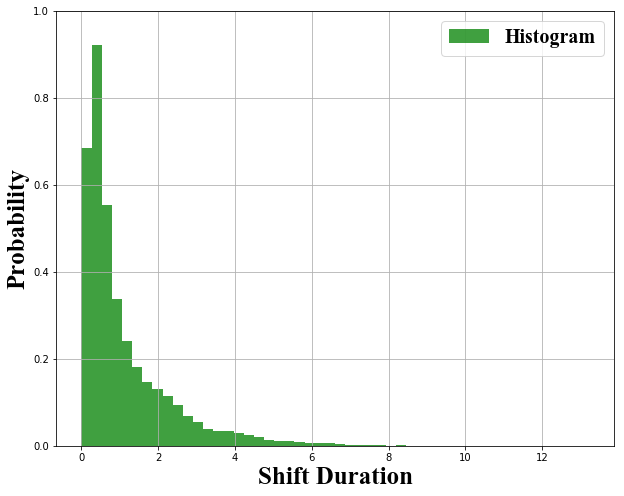

In [31]:
figsize = 10,8

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)


ax1.hist(Duration_Df.loc[(Duration_Df['Start Hour']==0)&(Duration_Df['label']=='A'),'Shift Duration'], 50,label='Histogram',facecolor='g', density=True, alpha=0.75)

ax1.set_ylabel('Probability',font_label)

ax1.set_xlabel('Shift Duration',font_label)

ax1.legend(loc = 'upper right',prop=font_legend)

ax1.set_ylim([0,1.0])

ax1.grid()

plt.show()






In [32]:
Labels=['A','B','C']

Duration={label:{h:{'mean':0.0,'std':0.0,'min':0.0,'max':0.0} for h in range(24)} for label in Labels}

for idx,row in Duration_Df.iterrows():
    
    label=row['label']
    
    h=row['Start Hour']
    
    Duration[label][h]['min']=row['min']
    Duration[label][h]['max']=row['max']
    Duration[label][h]['mean']=row['mean']
    Duration[label][h]['std']=row['std']
    
np.save(os.path.join(Save_Path,'Duration.npy'),Duration)


# Shift GAP Time

In [33]:
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 

Summary=Summary.sort_values(by=['Driver_id','Start Time'])

Gap_Df=pd.DataFrame([])

Gap_Df['Start Time']=Summary.groupby('Driver_id').apply(lambda x: x['Start Time'].to_list())

Gap_Df['End Time']=Summary.groupby('Driver_id').apply(lambda x: x['End Time'].to_list())

Gap_Df['Driver_id']=Gap_Df.index

def get_gap(Start,End):
    gap=list()
    if len(Start)==1:
        return gap
    else:
        for i in range(1,len(Start),1):
            gap.append([End[i-1],(Start[i]-End[i-1])/3600.0])
        return gap

Gap_Df['Gaps']=Gap_Df.apply(lambda x:get_gap(x['Start Time'],x['End Time']),axis=1)

Gap_Df['Length']=Gap_Df.apply(lambda x:len(x['Gaps']),axis=1)

Gap_Df=Gap_Df.loc[Gap_Df['Length']>0]

Gap_Df=Gap_Df.reset_index(drop=True)

Gap_Df = Gap_Df[['Driver_id','Gaps']]

Gap_Df=explode(Gap_Df,'Gaps')

Gap_Df['End Time']=Gap_Df.apply(lambda x:x['Gaps'][0],axis=1)

Gap_Df['Gap']=Gap_Df.apply(lambda x:round(x['Gaps'][1],2),axis=1)

Gap_Df['End Hour']=Gap_Df.apply(lambda x:int(Get_hour(x['End Time'])),axis=1)

Gap_Df=Gap_Df[['Driver_id','End Hour','Gap']]

Gap_Df=Gap_Df.merge(Driver_Df,on='Driver_id')

Gap_Df=Gap_Df[['label','End Hour','Gap']]

Gap_Df

,label,End Hour,Gap
0,A,12,3.52
1,A,15,2.59
2,A,7,3.08
3,A,0,2.13
4,A,9,5.52
5,A,9,10.35
6,A,11,2.48
7,A,17,4.85
8,C,12,3.39
9,C,16,2.79


In [34]:
Gap_STAT=pd.DataFrame([])

Gap_STAT['Gap']=Gap_Df.groupby(['End Hour','label']).apply(lambda x: x['Gap'].to_list())

Gap_STAT['Transition']=Gap_STAT.index

Gap_STAT['End Hour']=Gap_STAT.apply(lambda x:x['Transition'][0],axis=1)

Gap_STAT['label']=Gap_STAT.apply(lambda x:x['Transition'][1],axis=1)

Gap_STAT=Gap_STAT.reset_index(drop=True)

Gap_STAT['mean']=Gap_STAT.apply(lambda x:np.mean(x['Gap']),axis=1)

Gap_STAT['std']=Gap_STAT.apply(lambda x:np.std(x['Gap']),axis=1)

Gap_STAT['max']=Gap_STAT.apply(lambda x:Get_bound(x['Gap'])[1],axis=1)

Gap_STAT['min']=Gap_STAT.apply(lambda x:Get_bound(x['Gap'])[0],axis=1)

Gap_STAT=Gap_STAT[['End Hour','Gap','label','mean','std','max','min']]

Gap_STAT

,End Hour,Gap,label,mean,std,max,min
0,0,"[2.13, 12.86, 6.65, 18.74, 13.68, 19.32, 21.94...",A,13.280867,5.861176,21.52,2.66
1,0,"[6.9, 13.2, 11.88, 8.81, 7.61, 10.4, 8.84, 7.3...",B,9.272632,2.139738,12.78,5.91
2,1,"[12.51, 11.59, 13.62, 18.79, 20.94, 17.93, 11....",A,12.933407,5.947664,20.97,2.52
3,1,"[10.44, 7.13, 10.86, 8.99, 7.81, 7.77, 9.53, 5...",B,9.167750,1.805129,11.84,6.04
4,2,"[21.27, 11.15, 12.32, 14.31, 16.87, 21.04, 16....",A,12.566723,5.841896,20.23,2.43
5,2,"[8.14, 8.22, 10.65, 12.18, 7.1, 9.27, 12.6, 4....",B,7.561364,2.510388,12.18,3.06
6,3,"[19.23, 16.67, 18.1, 18.66, 11.22, 2.37, 15.08...",A,11.742191,5.914191,19.37,2.36
7,3,"[6.51, 6.19, 3.91, 3.1, 12.34, 13.73, 6.17, 3....",B,7.658824,3.629654,13.73,2.89
8,4,"[12.34, 3.83, 15.67, 4.27, 18.95, 5.31, 14.54,...",A,11.549013,5.793681,18.52,2.29
9,4,"[9.59, 5.04, 6.83, 9.65, 8.46, 12.75, 5.74, 4....",B,6.861053,3.331721,12.96,2.44


In [35]:
GAP={label:{h:{'mean':0.0,'std':0.0,'min':0.0,'max':0.0}for h in range(24)} for label in Labels}

for idx,row in Gap_STAT.iterrows():
    
    label=row['label']
    
    h=row['End Hour']

    GAP[label][h]['min']=row['min']
    GAP[label][h]['max']=row['max']
    GAP[label][h]['mean']=row['mean']
    GAP[label][h]['std']=row['std']
    
np.save(os.path.join(Save_Path,'GAP.npy'),GAP)

GAP


{'A': {0: {'mean': 13.280866521290026,
   'std': 5.861175706947439,
   'min': 2.66,
   'max': 21.52},
  1: {'mean': 12.933406986531987,
   'std': 5.947664023113336,
   'min': 2.52,
   'max': 20.97},
  2: {'mean': 12.566723390056724,
   'std': 5.8418956700358,
   'min': 2.43,
   'max': 20.23},
  3: {'mean': 11.742191405059433,
   'std': 5.914190847548337,
   'min': 2.36,
   'max': 19.37},
  4: {'mean': 11.549012875536482,
   'std': 5.793680804292463,
   'min': 2.29,
   'max': 18.52},
  5: {'mean': 10.304469777306469,
   'std': 5.55537665388981,
   'min': 2.27,
   'max': 17.52},
  6: {'mean': 8.629178970111633,
   'std': 5.023242146200329,
   'min': 2.21,
   'max': 16.29},
  7: {'mean': 6.531364113326338,
   'std': 3.8542571624253537,
   'min': 2.18,
   'max': 13.89},
  8: {'mean': 6.031861455686743,
   'std': 3.1799950620190613,
   'min': 2.19,
   'max': 12.01},
  9: {'mean': 5.512874125154386,
   'std': 2.7597552596659574,
   'min': 2.19,
   'max': 10.77},
  10: {'mean': 4.811674002347

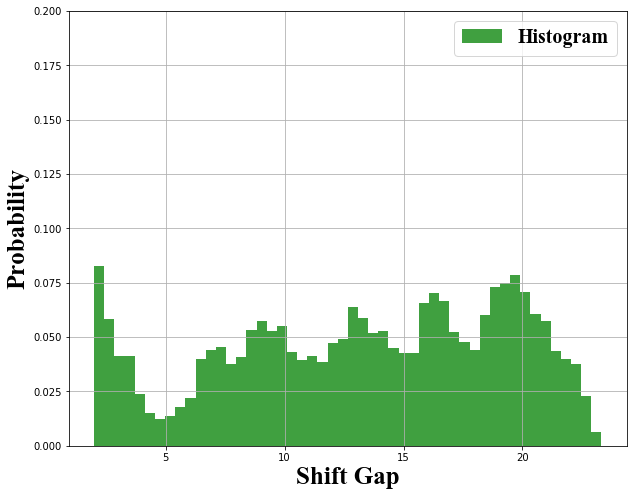

In [38]:
figsize = 10,8

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

ax1.hist(Gap_STAT.loc[(Gap_STAT['End Hour']==0)&(Gap_STAT['label']=='A'),'Gap'], 50,label='Histogram',facecolor='g', density=True, alpha=0.75)

ax1.set_ylabel('Probability',font_label)

ax1.set_xlabel('Shift Gap',font_label)

ax1.legend(loc = 'upper right',prop=font_legend)

ax1.set_ylim([0,0.2])

ax1.grid()

plt.show()
